In [2]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
mnist_train_data = MNIST(root='datasets/', train=True, download=True, 
                         transform=transforms.ToTensor())

mnist_test_data = MNIST(root='datasets/', train=False, download=True, 
                        transform=transforms.ToTensor())

image, label = mnist_train_data[0]
display(len(mnist_train_data), type(image), image.dtype, type(label))

60000

torch.Tensor

torch.float32

int

In [92]:
import pickle as pkl
with open("pickles/tensor_train.pkl","wb") as f:
    pkl.dump(mnist_train_data,f)

In [93]:
with open("pickles/tensor_train.pkl","rb") as f:
    mnist_train_data = pkl.load(f)

In [ ]:
with open("pickles/tensor_test.pkl","wb") as f:
    pkl.dump(mnist_test_data,f)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

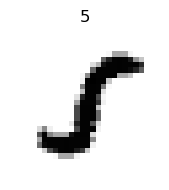

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(10, 2), tight_layout=True)
idx = np.random.permutation(len(mnist_train_data))[:10]

for k in range(1):
    image, label = mnist_train_data[idx[k]]
    ax.imshow(image[0, :, :].numpy(), cmap=plt.cm.Greys)
    ax.axis('off');
    ax.set_title(label)


In [60]:
import cv2
def tophat(img,kernel):
    img = img.numpy()
    erode = cv2.erode(img,kernel)
    dilate = cv2.dilate(erode,kernel)
    return np.subtract(dilate,img)

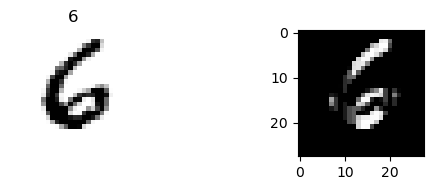

In [66]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
image,label = mnist_train_data[90]
fig, ax = plt.subplots(1,2, figsize=(10, 2), tight_layout=True)
ax[0].imshow(image[0,:,:],cmap=plt.cm.Greys)
ax[0].axis("off")
ax[0].set_title(label)
kernel = np.array([[1,1,1],
                   [1,1,1],
                   [1,1,1]],dtype=np.uint8)
kernel = np.ones(shape=(5,5),dtype=np.uint8)
img_nueva = tophat(image,kernel)
ax[1].imshow(img_nueva[0,:,:],cmap=plt.cm.Greys)

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

import torchvision.transforms.functional as T
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [68]:
def depthwise_conv2d(input, weight, bias=None, stride=1, padding=0):
    channels = input.size(1)  # Get the number of input channels
    depthwise_weight = weight.view(*weight.shape)

    output = F.conv2d(input=input, weight=depthwise_weight, bias=None, stride=stride, padding=padding, groups=channels)

    return output

In [71]:
class ProcessingUnitOpening(nn.Module):
    def __init__(self, filters, kernel_size, padding='same'):
        super(ProcessingUnitOpening, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding

        self.weights = nn.Parameter(torch.randn(self.kernel_size[0]**2, 1, *self.kernel_size ), requires_grad=True)
        self.weight_pw = nn.Parameter(torch.randn(1, 1, 1, 1))

        self.binary_weights = nn.Parameter(torch.zeros_like(self.weights), requires_grad=True)

    def forward(self, inputs):

    # Weights binarization
        with torch.no_grad():
            max_values, max_indices = torch.max(self.weights.view(self.weights.shape[0], -1), dim=1) # Find the maximum value and its index for each kernel
            self.binary_weights.data.zero_() # Create binary weights with array filled with zeros
            self.binary_weights.view(self.weights.shape[0], -1)[torch.arange(self.weights.shape[0]), max_indices] = 1.0 # Change max value position with 1.

        # First Depth-wise convolution using binary weights
        output_conv1 = depthwise_conv2d(input=inputs, weight=self.binary_weights, padding=self.padding)
        output_pool1, _ = torch.min(output_conv1, dim=1, keepdim=True)
        output1 = output_pool1

        # Second Depth-wise convolution using shared binary weights
        output_conv2 = depthwise_conv2d(input=output1, weight=self.binary_weights, padding=self.padding)
        output_pool2, _ = torch.max(output_conv2, dim=1, keepdim=True)
        output2 = output_pool2

        # Point-wise convolution
        output_pw = F.conv2d(output2, self.weight_pw, stride=1, padding='same')

        return output_pw

    def update_weights(self, learning_rate, gradient_binary_weights):
        self.weights.data = self.weights.data - learning_rate * gradient_binary_weights

In [83]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.processing_unit = ProcessingUnitOpening(filters=1, kernel_size=(5, 5), padding="same")

        self.flat = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(784,392),
            nn.ReLU(),
            nn.Linear(392,196),
            nn.ReLU(),
            nn.Linear(196,98),
            nn.ReLU(),
            nn.Linear(98,10)
        )
    def forward(self,x):
        x1 = self.processing_unit(x)
        x2 = np.subtract(x1.detach().numpy(),x)
        x3 = self.flat(x2)
        x4 = self.classifier(x3)
        return x4
model = CustomModel()
model

CustomModel(
  (processing_unit): ProcessingUnitOpening()
  (flat): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=98, bias=True)
    (5): ReLU()
    (6): Linear(in_features=98, out_features=10, bias=True)
  )
)

In [77]:
import torch
import torch.utils.data as tdata

mnist_train, mnist_valid = tdata.random_split(mnist_train_data, [50_000, 10_000], 
                                              generator=torch.Generator().manual_seed(1234))

In [78]:
train_loader = tdata.DataLoader(mnist_train, shuffle=True, batch_size=64)
valid_loader = tdata.DataLoader(mnist_valid, shuffle=False, batch_size=512)

In [84]:
def train_one_step(batch):
    optimizer.zero_grad()
    data, labels = batch
    data, labels = data.to(device), labels.to(device)
    preds = model.forward(data)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item() 

def evaluate_one_step(batch):
    with torch.no_grad():
        data, labels = batch
        data, labels = data.to(device), labels.to(device)
        preds = model.forward(data)
        loss = criterion(preds, labels)
        return loss.item()
    
def train_one_epoch(epoch):    
    train_loss, valid_loss = 0.0, 0.0    
    for batch in train_loader:
        train_loss += train_one_step(batch)    
    for batch in valid_loader:
        valid_loss += evaluate_one_step(batch)
        
    global best_valid_loss    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save({'epoca': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': valid_loss}, 
                   'best_model.pt')

    return train_loss/len(train_loader.dataset), valid_loss/len(valid_loader.dataset)


from tqdm.notebook import tqdm

model = CustomModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(reduction='sum')

device = torch.device('cpu')
#device = torch.device('cuda:0')
model = model.to(device)

max_epochs, best_valid_loss = 15, np.inf
running_loss = np.zeros(shape=(max_epochs, 2))
for epoch in tqdm(range(max_epochs)):
    running_loss[epoch] = train_one_epoch(epoch)

  0%|          | 0/15 [00:00<?, ?it/s]

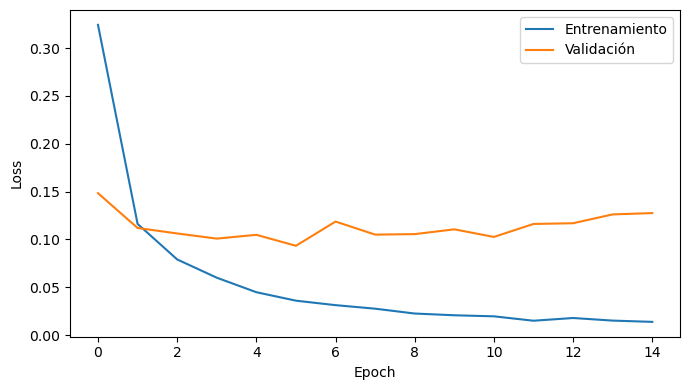

In [85]:
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
ax.plot(running_loss[:, 0], label='Entrenamiento')
ax.plot(running_loss[:, 1], label='Validación')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend();

In [86]:
model = CustomModel()
model.load_state_dict(torch.load('best_model.pt')['model_state_dict'])

<All keys matched successfully>

In [87]:
test_loader = tdata.DataLoader(mnist_test_data, shuffle=False, batch_size=512)
test_targets = mnist_test_data.targets.numpy()
prediction_test = []
for mbdata, label in test_loader:
    logits = model(mbdata).detach()
    prediction_test.append(logits.argmax(dim=1).numpy())
prediction_test = np.concatenate(prediction_test)

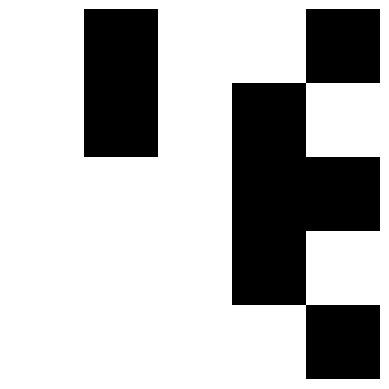

In [90]:
# Structuring element
trained_weights =  model.processing_unit.weights.detach().cpu().numpy()

s2 = np.zeros_like(trained_weights)
for i in range(trained_weights.shape[0]):
  w = trained_weights[i,:]
  max_w = w.max()
  w = (w >= max_w).astype(bool)

  s2[i,:] = w

se = np.sum(s2, axis=0)
se = (se >= 1).astype(np.int_)
se = np.squeeze(se)


plt.imshow(se, interpolation='nearest', cmap='gray')
plt.axis('off')
plt.show()

In [91]:
se

array([[1, 0, 1, 1, 0],
       [1, 0, 1, 0, 1],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 0, 1],
       [1, 1, 1, 1, 0]])

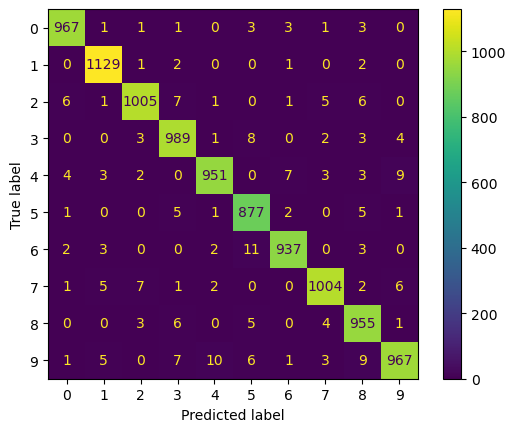

In [88]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

ConfusionMatrixDisplay.from_predictions(test_targets, prediction_test);

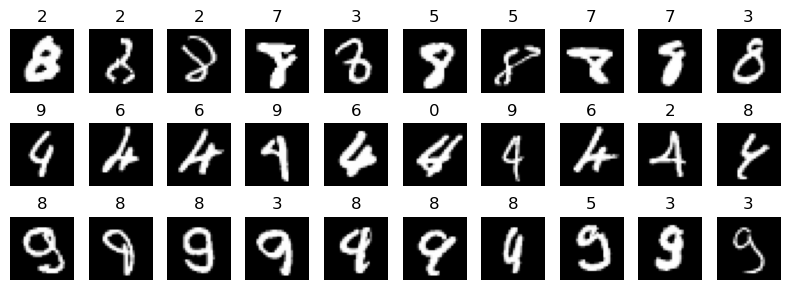

In [89]:
fig, ax = plt.subplots(3, 10, figsize=(8, 3), tight_layout=True)

for k, digit in enumerate([8, 4, 9]):    
    idx = np.where((test_targets == digit) & ~(prediction_test == digit))[0]
    for i in range(10):
        ax[k, i].axis('off')
        if i < len(idx):
            ax[k, i].set_title(prediction_test[idx[i]])
            ax[k, i].imshow(mnist_test_data[idx[i]][0].numpy()[0, :, :], cmap=plt.cm.Greys_r)
    